<a href="https://colab.research.google.com/github/danielesasso/PySpark-csv-query-with-LLM/blob/main/Colab_PySpark_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Initialization
* Prerequisites: Upload a CSV file into the Colab "files" (these are also available on GitHub) that is organized taxonomically (e.g., "skill-Linux") along with an ID block (e.g., "ID-name"). Also, modify the path in section 2.

* GPT API key (section 1.1.1)



### 1.1 pip install and API

In [ ]:
!pip install pyspark
!pip install langchain
!pip install openai==0.28
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *

import pandas as pd
import numpy as np

from collections import Counter
from langchain_community.document_loaders import PySparkDataFrameLoader
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain

import os
import json

import openai
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



#### 1.1.1 API GPT

**Insert your own API key below, between the " " marks.**

In [ ]:
openai.api_key = ""

### 1.2 Spark creation

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("PySpark LLM") \
    .getOrCreate()


## 2. Opening and reading of the .csv file
**Change the path .load("populated_matrix.csv") to the name of the CSV file you intend to use.**

In [ ]:
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("populated_matrix.csv")

#takes in input the column name
columns = df.columns

print the number of users (row) and number of features (column)

In [ ]:
num_columns = len(df.columns)
num_rows = df.count()

print(f"N. column (features): {num_columns}")
print(f"N. row (users): {num_rows}")


Numero colonne (features): 129
Numero righe (users): 2104


## 3 Thematic blocks
Using PySpark, I extract the thematic blocks from the taxonomic CSV file, separated by a dash (e.g., tools-Laser).

In [ ]:
# Creates a RDD from the column names
columns_rdd = spark.sparkContext.parallelize(columns)

# Extract the thematic blocks from each columns (the blocks are separated from the feature name from the '-')
thematic_blocks_rdd = columns_rdd.map(lambda col: col.split('-', 1)[0])

# Counts all the recurrencies from each blocks
counts = dict(thematic_blocks_rdd.map(lambda block: (block, 1))
                              .reduceByKey(lambda a, b: a + b)
                              .collect())

print("N. of different thematic blocks:", len(counts))
for block, freq in counts.items():
    print(f"{block} -> {freq} cloumns")

# Build a dictionary containing each blocks: {name_block: [column1, column2, ...]}
blocks_dict = dict(
    columns_rdd.map(lambda col: (col.split('-', 1)[0], col))
               .groupByKey()
               .mapValues(list)
               .collect()
)

print("Block structures:")
print(json.dumps(blocks_dict, indent=2))


Numero di blocchi tematici distinti: 8
work_activities -> 9 colonne
knowledge -> 15 colonne
tech_skills -> 39 colonne
abilities -> 8 colonne
tasks -> 26 colonne
ID -> 2 colonne
tools -> 16 colonne
skills -> 14 colonne
Struttura dei blocchi estratti dinamicamente:
{
  "work_activities": [
    "work_activities-Resolving Conflicts and Negotiating with Others",
    "work_activities-Evaluating Information to Determine Compliance with Standards",
    "work_activities-Processing Information",
    "work_activities-Developing Objectives and Strategies",
    "work_activities-Establishing and Maintaining Interpersonal Relationships",
    "work_activities-Making Decisions and Solving Problems",
    "work_activities-Thinking Creatively",
    "work_activities-Getting Information",
    "work_activities-Training and Teaching Others"
  ],
  "knowledge": [
    "knowledge-Customer and Personal Service",
    "knowledge-Design",
    "knowledge-Production and Processing",
    "knowledge-English Language",
 

## 4 LLM-Query

### 4.1 parsing query with gpt
Use GPT to analyze the user's query and identify which blocks and/or features might be relevant.

* Assign a weight (from 0 to 1) to each feature/block.

In [ ]:
def parse_user_query_strict(query, blocks_dictionary):
    """
    Gives back a dictionary with the following structure:
    {
      "relevant_blocks": [
        {
          "block_name": "blockname",
          "weight": 0.8
        }
      ],
      "relevant_features": [
        {
          "name": "columnname",
          "weight": 1.0
        }
      ]
    }
    """

    # Prompt per GPT: We ask it to be very selective,
    # adding a request to assign a weight from 0 to 1.
    prompt = f"""
    Devi analizzare la query di un utente su un dataset di skill,
    DIVISO IN BLOCCHI, ognuno con diverse colonne (feature).
    Ecco la struttura (blocks_dictionary) in JSON:
    {json.dumps(blocks_dictionary, indent=2)}

    L'utente fa la seguente richiesta: "{query}"

    *SII MOLTO SELETTIVO*:
    - Se la colonna o il blocco non è strettamente correlato alla richiesta, NON includerlo.
    - Se ritieni che l'utente voglia TUTTO il blocco, allora aggiungi un oggetto in "relevant_blocks"
      con {{"block_name": "NomeBlocco", "weight": <valore 0-1>}}.
    - Se invece l'utente è interessato a UNA o POCHI argomenti all'interno di un blocco,
      indica le feature (colonne) specifiche in "relevant_features",
      con {{"name": "NomeColonna", "weight": <valore 0-1>}}.
    - Non aggiungere nulla che non sia chiaramente correlato alla query.
    - Se una skill è più importante, assegnale un peso più alto (vicino a 1).
      Se è rilevante ma secondaria, peso intermedio (0.3-0.7).
    - Restituisci SOLO un JSON **valido** con questa struttura:
    {{
      "relevant_blocks": [
        {{
          "block_name": "NomeBlocco",
          "weight": 0.8
        }}
      ],
      "relevant_features": [
        {{
          "name": "NomeColonna",
          "weight": 1.0
        }}
      ]
    }}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "Sei un assistente che analizza la query dell'utente "
                        "per trovare i blocchi e/o le feature più rilevanti, "
                        "assegnando pesi (0-1) in modo selettivo."
                    )
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.0
        )
        content = response["choices"][0]["message"]["content"]
        parsed_json = json.loads(content)
        return parsed_json
    except (json.JSONDecodeError, KeyError):
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }
    except Exception as e:
        print("Errore inaspettato nella chiamata a GPT:", e)
        return {
            "relevant_blocks": [],
            "relevant_features": []
        }


### 4.2 Function for Corresponding Columns
* Takes the list of thematic blocks and features.
* Creates a new set.
* Checks if GPT indicates a block or one or more features and adds them to the set, returning it.
* If an entire block is requested, the whole block is assigned; otherwise, only the specified features are assigned.

In [ ]:

def find_relevant_columns(parsed_dict, blocks_dictionary):
    """
    Given all blocks/features with their weights (from 0 to 1),
    builds another dictionary {column: weight} to select.

   Selection logic remains unchanged (very strict),
   with the difference that the relevant_blocks and relevant_features are lists of objects:
      { "block_name": "...", "weight": ... }
      { "name": "...",        "weight": ... }

    - If GPT includes a block in 'relevant_blocks'
     but also specifies some features of that block in 'relevant_features',
     we take ONLY those features.
    - If GPT includes a block (weight=W) but doesnt specify any features in it,
      we'll include all the blocks with weights=W.
    - If GPT specify a feature from a block not present in 'relevant_blocks',
      we'll include only that feature.


    """

    relevant_blocks = parsed_dict.get("relevant_blocks", [])
    relevant_feats = parsed_dict.get("relevant_features", [])

    #Build a dictionary: block_name -> weight
    block_weights = {}
    for b in relevant_blocks:
        bname = b.get("block_name")
        w = b.get("weight", 0.5)  # default 0.5 se non presente
        if bname and bname in blocks_dictionary:
            block_weights[bname] = w

    #Build a dictionary: feature_name -> weight
    feature_weights = {}
    for f in relevant_feats:
        fname = f.get("name")
        w = f.get("weight", 0.5)
        if fname:
            feature_weights[fname] = w

    #We build the final dictionary: col -> weight
    final_col_weights = {}

    # 1) If a block is listed, but GPT has specified features for that block
    #    we'll only use those features along with their associated weights;
    #    otherwise, we include the entire block with the block's weight.
    for block_name, wblock in block_weights.items():
        # Check if there are any features in this block
        block_specific_feats = []
        for feat_name, wfeat in feature_weights.items():

            # Check if feat_name belongs to the  blocks_dictionary
            cols_in_block = blocks_dictionary.get(block_name, [])
            if feat_name in cols_in_block:
                block_specific_feats.append((feat_name, wfeat))

        if len(block_specific_feats) > 0:
            # We have specific features so we'll add only those
            for (colname, colweight) in block_specific_feats:
                final_col_weights[colname] = colweight
        else:
            # No features, we'll include all the block
            for col in blocks_dictionary.get(block_name, []):
                final_col_weights[col] = wblock

    # 2) Handling of features not mentioned in relevant_blocks (or mentioned outside of a block):
    #       If GPT has provided, for any feature (f.name, f.weight),
    #       and the block is not in block_weights, we add it anyway.
    for feat_name, wfeat in feature_weights.items():
        # if not already inserted
        if feat_name not in final_col_weights:
            final_col_weights[feat_name] = wfeat

    # Prints each features with each weight
    print("Features (columns) founded by GPT with their weights:")
    for col, w in final_col_weights.items():
        print(f"  - {col} -> {w}")

    return final_col_weights


### 4.3 Query request and execution operation:
* The user is prompted for a query (i.e.:a request for specific abilities that users might have in the dataset) which will be sent to GPT for the analysis of the existing features.

In [ ]:
user_query = input("Benvenuto!\nPuoi chiedermi di identificare persone o gruppi basati su abilità specifiche, conoscenze linguistiche, o altri criteri presenti nel dataset.\nPer esempio, potresti chiedere: 'Chi sa parlare inglese?' oppure 'Chi ha le competenze necessarie per costruire una casa?'.\nChe tipo di utenti stava cercando? ")

#parsing query
parsed_result = parse_user_query_strict(user_query, blocks_dict)

#Obtain the dictionary {column: weight} instead of a list
col_weights_dict = find_relevant_columns(parsed_result, blocks_dict)

#If not present any columns
if len(col_weights_dict) == 0:
    print("No features founded by GPT.")

    # Show only the ID
    id_block_columns = blocks_dict.get("ID", [])
    df.select(id_block_columns).show(truncate=False)
else:
    #At the beginning we'll always add the block "ID"
    id_block_columns = blocks_dict.get("ID", [])
    final_columns_with_weights = {}

    #Insert ID without any weight
    for col_id in id_block_columns:
        if col_id in df.columns:
            final_columns_with_weights[col_id] = None

    #Add the column founded by GPT (col->weight)
    for c, w in col_weights_dict.items():
        if c in df.columns:
            final_columns_with_weights[c] = w

    #Sort the features:
    #    - first "ID" in order
    #    - then the skills
    id_cols = list(final_columns_with_weights.keys())[:len(id_block_columns)]  #i primi len(id_block_columns) sono ID
    skill_cols_and_weights = [(c, w) for c, w in final_columns_with_weights.items() if w is not None]
    skill_cols_and_weights.sort(key=lambda x: x[1], reverse=True)

    #Build the final list
    final_columns = id_cols + [x[0] for x in skill_cols_and_weights]

    print("Final column (ID + skill with weight):", final_columns)


    #Spark filter: takes all the users who have at least a skill = 1 of the selected one
    skill_only_columns = [x[0] for x in skill_cols_and_weights]
    if skill_only_columns:
        #Creates a NOR condition if any skill present
        filter_conditions = [F.col(c) == 1 for c in skill_only_columns]
        combined_filter = reduce(Column.__or__, filter_conditions)
        df_filtered = df.filter(combined_filter).select(final_columns)
    else:
        #If there isnt any skills, select only ID
        df_filtered = df.select(final_columns)

Inserisci la query: chiunque sappia programmare in qualsiasi modo, che sia linux o coding, apprezzato se conoscono altre lingue o l'inglese, è meno importanto ma gradito se rispettano le date di scadenza e sono in buona forma fisica
Feature (o colonne) trovate da GPT con peso:
  - tech_skills-Linux -> 1.0
  - knowledge-Foreign Language -> 0.7
  - knowledge-English Language -> 0.7
  - abilities-Control Precision -> 0.3
  - skills-Programming -> 1.0
  - work_activities-Making Decisions and Solving Problems -> 0.5
Colonne finali da selezionare (ID + skill ordinate per peso): ['ID-ID', 'ID-name', 'tech_skills-Linux', 'skills-Programming', 'knowledge-Foreign Language', 'knowledge-English Language', 'work_activities-Making Decisions and Solving Problems', 'abilities-Control Precision']


In [ ]:
#print user query
print(user_query)

chiunque sappia programmare in qualsiasi modo, che sia linux o coding, apprezzato se conoscono altre lingue o l'inglese, è meno importanto ma gradito se rispettano le date di scadenza e sono in buona forma fisica


### 4.4 Save the results in a pandas DataFrame
* This is done to allow us to use graphs
* sort the users so that those with the most important skills appear at the top.








In [ ]:
def convert_spark_to_pandas(spark_df):
    columns = spark_df.columns
    data = []
    for row in spark_df.collect():
        data.append(row.asDict())
    return pd.DataFrame(data, columns=columns)

In [ ]:
pdf = convert_spark_to_pandas(df_filtered)

# 2) weighted sum
weighted_scores = []
for idx, row in pdf.iterrows():
    score = 0.0
    for col in skill_only_columns:
        skill_value = row[col]  # 0 or 1
        weight = col_weights_dict.get(col, 0)
        score += skill_value * weight
    weighted_scores.append(score)

pdf['weighted_score'] = weighted_scores

# 3) Sort the result based on the score
pdf_sorted = pdf.sort_values('weighted_score', ascending=False)

# 4) Remove 'weighted_score' from the pdf_sorted
pdf_sorted.drop(columns=[pdf_sorted.columns[-1]], inplace=True)

# Let's create a mapping "weight → fraction" to use a single color for columns sharing the same weight.
unique_weights = sorted({col_weights_dict.get(c, 0) for c in skill_only_columns})
if len(unique_weights) > 1:
    min_w, max_w = unique_weights[0], unique_weights[-1]
    weight_to_fraction = {
        w: (w - min_w) / (max_w - min_w)
        for w in unique_weights
    }
else:
    # If its present only one weight (or anything), we'll assign a stable fraction weight
    weight_to_fraction = {w: 0.5 for w in unique_weights}

## 5. Rank users and visualize graphs
* Create a hybrid "heatmap" to better interpret the data.

### 5.1 Heatmap table

Ci sono 1591 utenti, quanti ne vuoi visualizzare? (inserisci un numero o 'tutti'): 20


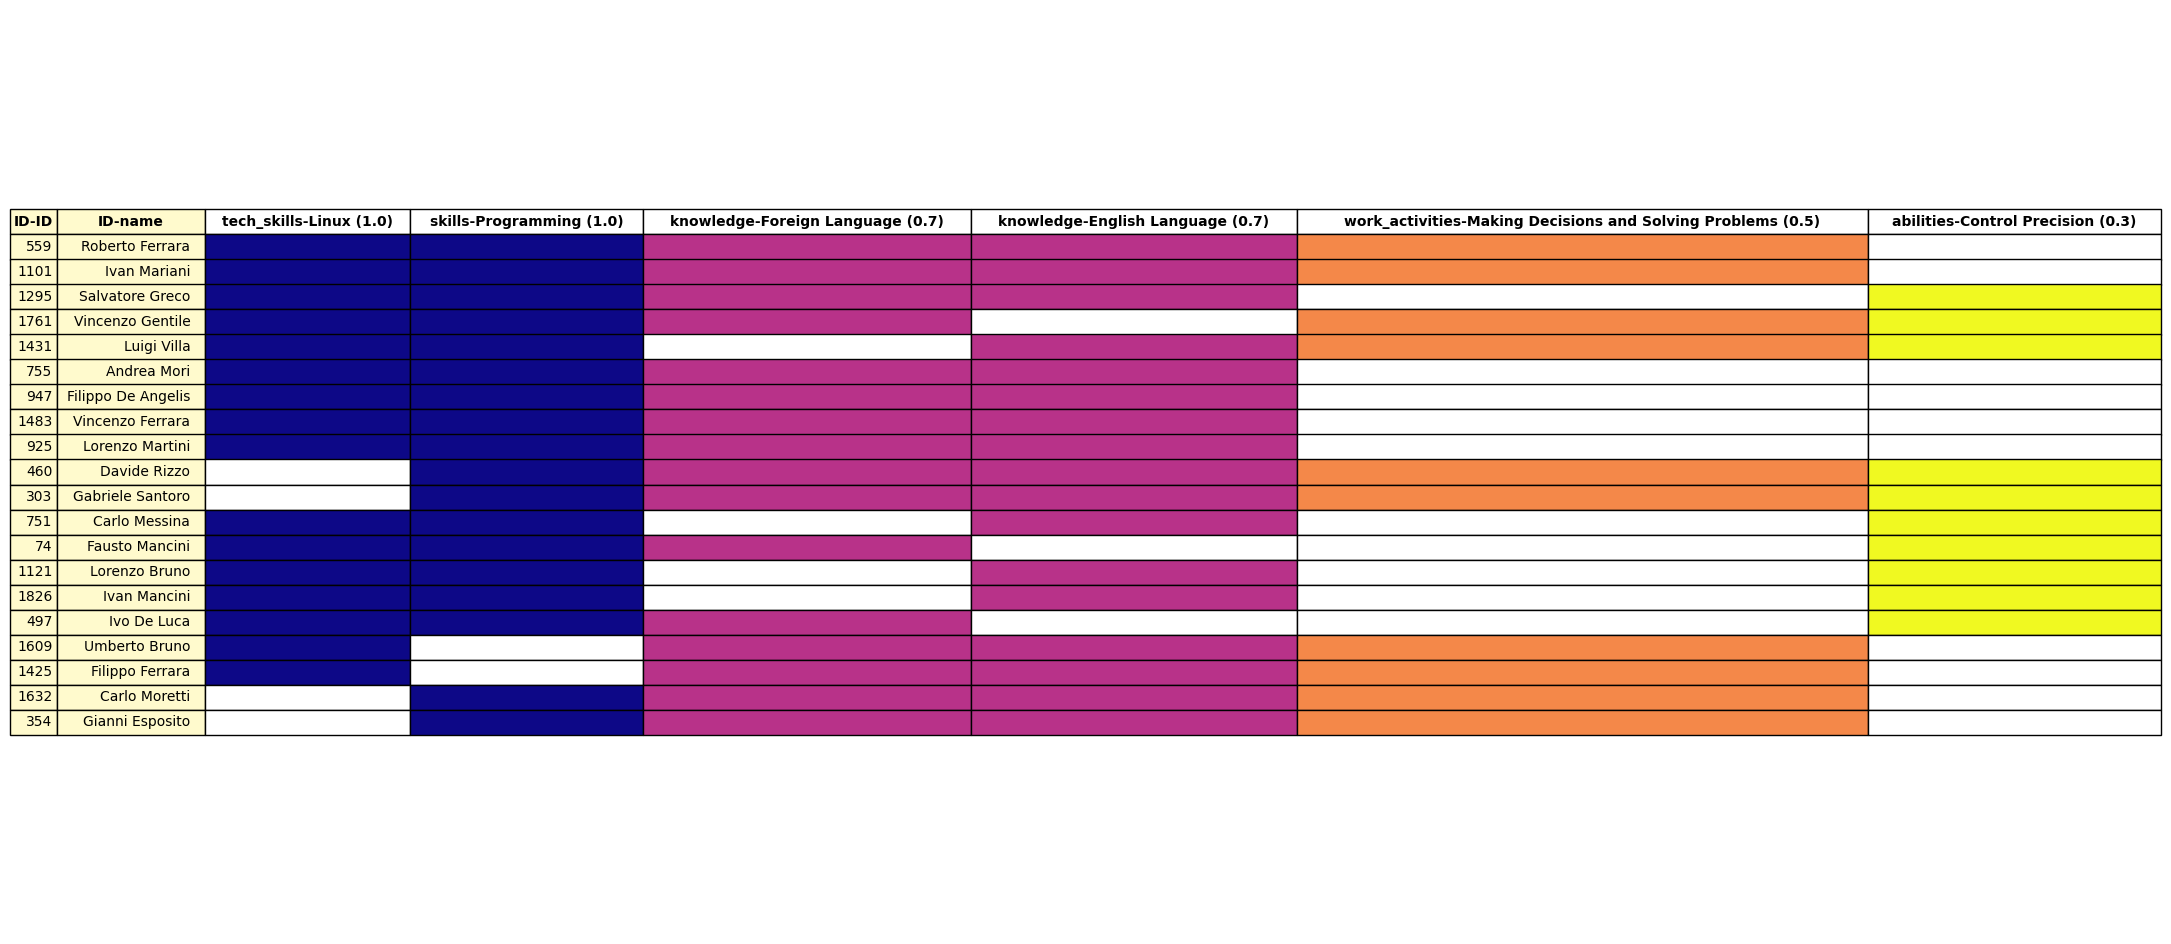

In [ ]:

pdf_table = pdf_sorted.copy()  # clone pdf_sorted

num_users = len(pdf_table)
scelta = input(f"There are {num_users} users, how many do you want to display? (enter a number or 'all'):")

if scelta.lower() == 'tutti':
    # we dont apply any filter
    pass
else:
    try:
        n = int(scelta)
        # if scelta > than the num_users, we'll show everyone
        if n > num_users:
            n = num_users
        pdf_table = pdf_table.head(n)
    except ValueError:
        # if the input is not a number, we visualize everyone
        print("Not a number, we'll show everyone:")

# If after the selection the DataFrame is empty, we signal that there are no users.
if pdf_table.empty:
    print("There are no users to display.")

# -----------------------------------------------------------------------------
# pdf_table creation
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 0.6 * len(pdf_table)))
ax.axis('off')

# Creates the new labels with weight
new_col_labels = []
for col in pdf_table.columns:
    if col.startswith("ID-"):
        # No weights on ID
        new_col_labels.append(col)
    else:
        w = col_weights_dict.get(col, 0)
        new_col_labels.append(f"{col} ({w})")

# Creates the table
table = ax.table(
    cellText=pdf_table.values.astype(str),
    colLabels=new_col_labels,
    loc='center'
)

# Bold header and font dimension
for col_index, label in enumerate(pdf_table.columns):
    cell_header = table.get_celld()[(0, col_index)]
    cell_header.get_text().set_weight('bold')
    cell_header.set_fontsize(10)

    # "ID-" label color
    if label.strip().startswith("ID-"):
        cell_header.set_facecolor('LemonChiffon')

# Size up the cell table
table.scale(1.5, 1.5)

# We obtain the nrwos and ncols
nrows = len(pdf_table)
ncols = len(pdf_table.columns)

# Colormap
cmap = plt.get_cmap('plasma')

# Rows loop (start from 1)
for i in range(nrows):
    for j in range(ncols):
        cell = table.get_celld()[(i + 1, j)]
        val_str = pdf_table.iloc[i, j]

        # Verify if the first column is "ID-"
        if pdf_table.columns[j].strip().startswith("ID-"):
            cell.set_facecolor('LemonChiffon')
            continue

        # float conversion
        try:
            val = float(val_str)
        except ValueError:
            # if not convertible, it'll stay white
            cell.set_facecolor('white')
            continue

        if pd.isna(val) or val == 0.0:
            # Se 0 or NaN => white cell
            cell.set_facecolor('white')
            cell.get_text().set_text('')
        else:
            # weight of the column
            col_name = pdf_table.columns[j]
            w = col_weights_dict.get(col_name, 0)


            fraction = weight_to_fraction.get(w, 0.0)
            color = cmap(1 - fraction)
            cell.set_facecolor(color)
            cell.get_text().set_text('')

table.auto_set_column_width(col=list(range(ncols)))

plt.show()

### 5.2 Frequency barplot

* Frequency barplot of the skills

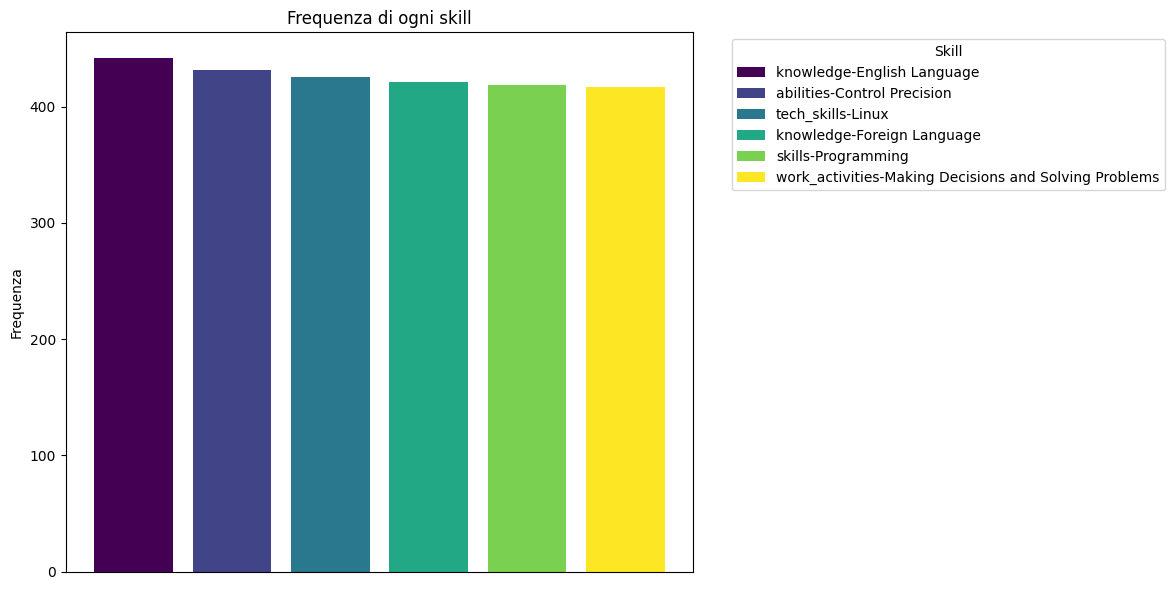

In [ ]:
# Calculate the skill frequency
skill_sums = pdf_sorted[skill_only_columns].sum()

# sort the skill desc based on the frequency
sorted_skill_sums = skill_sums.sort_values(ascending=False)

# 'viridis' palette
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_skill_sums)))

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_skill_sums.index, sorted_skill_sums.values, color=bar_colors)

# etiquette of each bar
for bar, skill in zip(bars, sorted_skill_sums.index):
    bar.set_label(skill)

plt.xticks([])

# Label on the right
plt.legend(title='Skill', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Frequency of each skill")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 6 tkinter
* Create an SVG with the same ordering as the previous table **(5.1)**, but without column names and row names, favoring pixel compression to facilitate visualization in case of many data.

In [ ]:
import html
import json
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog

#  Pixel dimension and colormap
PIXEL_SIZE = 15
cmap = plt.get_cmap('plasma')

# Function to convert the weight into a hexadecimal color.
def weight_to_hex_color(w, weight_to_fraction):
    fraction = weight_to_fraction.get(w, 0.0)
    rgba = cmap(1.0 - fraction)
    return f"rgb({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)})"

# Function to create the interactive SVG
def generate_interactive_svg(pdf, skills, col_weights, weight_to_fraction, pixel_size=PIXEL_SIZE):
    width = len(skills) * pixel_size
    height = len(pdf) * pixel_size
    svg_content = [
        f'<svg width="{width}" height="{height}" viewBox="0 0 {width} {height}" xmlns="http://www.w3.org/2000/svg">\n'
        f'<rect x="0" y="0" width="{width}" height="{height}" fill="white"/>\n'
        '<script type="text/javascript"><![CDATA[\n'
        'function showUserInfo(userData, skill) {\n'
        '  let info = `Skill: ${skill}\\n`;\n'
        '  Object.entries(userData).forEach(([key, value]) => {\n'
        '    info += `${key}: ${value}\\n`;\n'
        '  });\n'
        '  alert(info);\n'
        '}\n'
        ']]></script>'
    ]

    for row_idx, (_, row) in enumerate(pdf.iterrows()):
        for col_idx, skill_name in enumerate(skills):
            if row[skill_name] == 1:
                w = col_weights.get(skill_name, 0.0)
                color = weight_to_hex_color(w, weight_to_fraction)
                x = col_idx * pixel_size
                y = row_idx * pixel_size
                user_data = {str(k): str(v) for k, v in row.items()}
                user_data_json = json.dumps(user_data, ensure_ascii=False)
                skill_json = json.dumps(skill_name, ensure_ascii=False)
                escaped_user_data_json = html.escape(user_data_json, quote=True)
                escaped_skill_json = html.escape(skill_json, quote=True)

                svg_content.append(
                    f'<rect x="{x}" y="{y}" width="{pixel_size}" height="{pixel_size}" '
                    f'fill="{color}" stroke="none" '
                    f'onclick="showUserInfo({escaped_user_data_json}, {escaped_skill_json})"/>'
                )

    svg_content.append('</svg>')
    return '\n'.join(svg_content)

def display_interactive_svg(pdf_sorted, skill_only_columns, col_weights, weight_to_fraction, pixel_size=PIXEL_SIZE):
    # Creates a local copies
    local_pdf = pdf_sorted.copy()
    local_skills = skill_only_columns.copy()

    # User request
    choice = int(input(
        "Vuoi modificare il grafico? Inserisci:\n"
        "- 0 se vuoi visualizzare il grafico per intero\n"
        "- 1 se vuoi eliminare feature\n"
        "- 2 se vuoi visualizzare meno utenti\n"
        "- 3 se vuoi eliminare feature e visualizzare meno utenti\n"
        "Scegli un'opzione: "
    ).strip())

    # Features rimotion
    if choice == 1 or choice == 3:
        # Construct the message for the available features (excluding any columns that start with "id").
        features_filtrate = [col for col in local_skills if not col.lower().startswith("id")]
        message = "Elenco feature disponibili per la rimozione:\n0. Nessuna\n"
        message += "\n".join(f"{idx}. {feat}" for idx, feat in enumerate(features_filtrate, start=1))
        to_remove_str = input(
            f"{message}\nInserisci gli indici delle feature da rimuovere, separati da virgola (esempio: 1,2,5): "
        )
        indices_to_remove = [int(x.strip()) for x in to_remove_str.split(",") if x.strip().isdigit()]
        if 0 not in indices_to_remove:
            feature_da_rimuovere = [features_filtrate[i - 1] for i in indices_to_remove if 1 <= i <= len(features_filtrate)]
            # Remove the features and skill from the local datafram
            local_skills = [col for col in local_skills if col not in feature_da_rimuovere]
            local_pdf = local_pdf.drop(columns=feature_da_rimuovere, errors='ignore')

    # if the user wanna show less rows
    if choice == 2 or choice == 3:
        total_users = len(local_pdf)
        user_input = input("Ci sono {} utenti, quanti ne vuoi visualizzare? Inserisci 'tutti' se vuoi visualizzarli tutti: ".format(total_users)).strip().lower()
        if user_input != 'tutti':
            try:
                num_users = int(user_input)
                local_pdf = local_pdf.head(num_users)
            except ValueError:
                print("Inserimento non valido, verranno visualizzati tutti gli utenti.")

    # Generates the interactive SVG
    svg_output = generate_interactive_svg(local_pdf, local_skills, col_weights, weight_to_fraction, pixel_size)

    # Visualize the SVG in the notebook
    display(HTML(svg_output))

# e.g:
display_interactive_svg(pdf_sorted, skill_only_columns, col_weights_dict, weight_to_fraction)


Vuoi modificare il grafico? Inserisci:
- 0 se vuoi visualizzare il grafico per intero
- 1 se vuoi eliminare feature
- 2 se vuoi visualizzare meno utenti
- 3 se vuoi eliminare feature e visualizzare meno utenti
Scegli un'opzione: 2
Ci sono 1591 utenti, quanti ne vuoi visualizzare? Inserisci 'tutti' se vuoi visualizzarli tutti: 30
